In [3]:
from transformers import ViTImageProcessor, ViTForImageClassification
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pickle

import plotly.express as px
import pandas as pd

external_path=''

In [4]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, in_dimension: int, bias=True):
        super().__init__()
        self.in_dimension=in_dimension
        self.linear=torch.nn.Linear(in_dimension,1)
        self.sigmoid=torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sigmoid(self.linear(x))

In [13]:
def get_dataset(category,opposing_category,layer):
    for k in range(1,11):
        if k==1:
            category_activations=torch.load(f'{external_path}\\class_token_activations\\{category}\\layer{layer}_{k}.pt')
        else:
            activations=torch.load(f'{external_path}\\class_token_activations\\{category}\\layer{layer}_{k}.pt')
            category_activations=torch.cat([category_activations,activations])
    for n,opp_category in enumerate(opposing_category):
        for k in range(1,11):
            if n==0 and k==1:
                opp_category_activations=torch.load(f'{external_path}\\class_token_activations\\{opp_category}\\layer{layer}_{k}.pt')
            else:
                activations=torch.load(f'{external_path}\\class_token_activations\\{opp_category}\\layer{layer}_{k}.pt')
                opp_category_activations=torch.cat([opp_category_activations,activations])
    activation_dim=category_activations.shape[-1]
    dataset_size=category_activations.shape[0]+opp_category_activations.shape[0]

    dataset=torch.zeros((dataset_size,activation_dim+1))
    for k,ten in enumerate(category_activations):
        dataset[k,:activation_dim]=ten
        dataset[k,-1]=1
    for l, ten in enumerate(opp_category_activations):
        dataset[k+l,:activation_dim]=ten
        dataset[k+l,-1]=0
    dataset=dataset[torch.randperm(dataset_size)]
    return dataset,category_activations.shape[0],opp_category_activations.shape[0]

In [6]:
def train(dataset,batch_size=64,lr=1e-3,epochs=100,verbose=False,shuffle=True):
    activation_dim=dataset.shape[-1]-1
    dataset_size=dataset.shape[0]
    model=LinearClassifier(activation_dim)
    optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    criterion=torch.nn.BCELoss()

    if verbose:
        progress_bar=tqdm(range(epochs))
    else:
        progress_bar=range(epochs)

    for epoch in progress_bar:
        epoch_loss=0
        if shuffle:
            dataset=dataset[torch.randperm(dataset_size)].detach()
        epoch_cycles=dataset_size//batch_size
        for k in range(epoch_cycles+1):
            optimizer.zero_grad()
            if k==epoch_cycles:
                inputs=dataset[k*batch_size:,:activation_dim]
                labels=dataset[k*batch_size:,-1]
            else:
                inputs=dataset[k*batch_size:(k+1)*batch_size,:activation_dim]
                labels=dataset[k*batch_size:(k+1)*batch_size,-1]
            outputs=model(inputs).reshape((len(labels),))
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            epoch_loss+=loss
        if verbose:
            progress_bar.set_description(f"Loss={epoch_loss/dataset_size:.4f}")
        if loss<1e-5 and epoch>=49:
            break
    return model, epoch_loss/dataset_size, epoch

In [7]:
def concept_vector(model):
    cav=model.linear.weight[0].detach()
    return cav/torch.norm(cav,p=2)

In [12]:
for layer in range(13):
    if not(os.path.exists(f'{external_path}\\concept_activation_vectors\\{layer}')):
        os.mkdir(f'{external_path}\\concept_activation_vectors\\{layer}')

losses={}

categories=os.listdir(f'{external_path}\\class_token_activations')
progress_bar=tqdm(categories)
N=len(categories)
category_num=1
for category in progress_bar:
    if not(os.path.exists(f'{external_path}\\concept_activation_vectors\\{layer}\\{category}')):
        os.mkdir(f'{external_path}\\concept_activation_vectors\\{layer}\\{category}')
    for layer in range(0,13):
        progress_bar.set_description(f'...processing {category} ({category_num}/{N}) layer {layer}...')
        opp_categories=[cat for cat in categories if cat!=category]
        dataset,num_cat_act,num_opp_cat_act=get_dataset(category,opp_categories,layer)
        model,loss,epoch=train(dataset)
        cav=concept_vector(model)
        torch.save(cav,f'{external_path}\\concept_activation_vectors\\{layer}\\{category}.pt')

        if layer in losses.keys():
            losses[layer][category]=loss.item()
        else:
            losses[layer]={category:loss.item()}
    category_num+=1

for layer in range(13):
    losses_file=open(f'{external_path}\\concept_activation_vectors\\{layer}\\training_losses','wb')
    pickle.dump(losses[layer],losses_file)
    losses_file.close()

...processing airplane (1/10) layer 0...:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1

...processing airplane (1/10) layer 0...:   0%|          | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: 

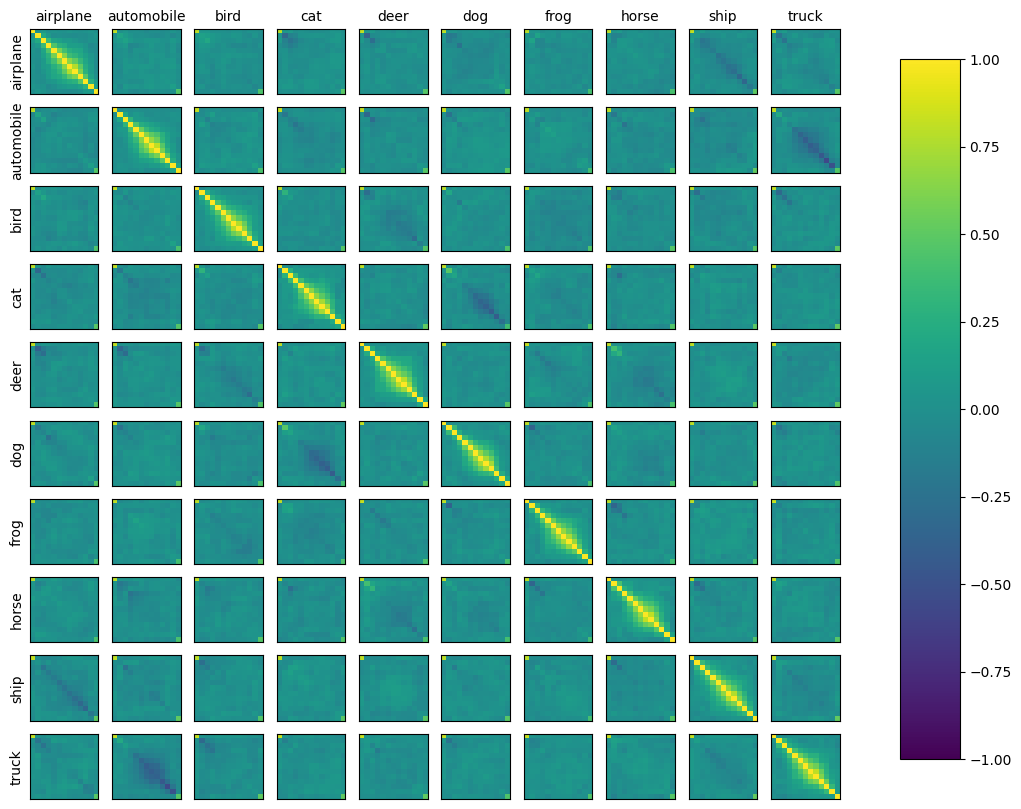

In [42]:
categories=os.listdir(f'{external_path}\\class_token_activations')
N=len(categories)
fig,axs=plt.subplots(nrows=N,ncols=N)
fig.set_figheight(10)
fig.set_figwidth(12)
for n,cat_1 in enumerate(categories):
    for m,cat_2 in enumerate(categories):
        dot_products=np.ones((13,13))
        for layer_1 in range(13):
            for layer_2 in range(13):
                cav_1=torch.load(f'{external_path}\\concept_activation_vectors\\{layer_1}\\{cat_1}.pt')
                cav_2=torch.load(f'{external_path}\\concept_activation_vectors\\{layer_2}\\{cat_2}.pt')
                dot_products[layer_1,layer_2]=torch.dot(cav_1,cav_2)
                dot_products[layer_2,layer_1]=torch.dot(cav_2,cav_1)
        im=axs[n][m].imshow(dot_products,aspect='auto',vmin=-1, vmax=1)
        axs[n][m].xaxis.set_visible(False)
        if m==0:
            axs[n][m].set_ylabel(cat_1)
        if n==0:
            axs[n][m].set_title(cat_2,fontsize=10)
        axs[n][m].tick_params(left=False, labelleft=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [14]:
cumulative_losses={}

for layer in range(13):
    layer_losses_file=open(f'{external_path}\\concept_activation_vectors\\{layer}\\training_losses','rb')
    layer_losses=pickle.load(layer_losses_file)
    layer_losses_file.close()

    for relation in layer_losses.keys():
        if relation in cumulative_losses.keys():
            cumulative_losses[relation]=cumulative_losses[relation]+[layer_losses[relation]]
        else:
            cumulative_losses[relation]=[layer_losses[relation]]

cumulative_losses_df=pd.DataFrame.from_dict(cumulative_losses)

fig=px.line(cumulative_losses_df)

fig.update_layout(title="CAV Training Losses",xaxis_title="Layer",yaxis_title="Loss",legend_title="Concept")

fig.show()

In [8]:
for layer in range(0,13):
    if not(os.path.exists(f'{external_path}\\relative_concept_activation_vectors\\{layer}')):
        os.mkdir(f'{external_path}\\relative_concept_activation_vectors\\{layer}')

losses={}

categories=os.listdir(f'{external_path}\\class_token_activations')
progress_bar=tqdm(categories)
N=len(categories)
for cat_1 in progress_bar:
    for k,cat_2 in enumerate(categories):
        if cat_1==cat_2:
            continue
        for layer in range(0,13):
            progress_bar.set_description(f'...processing {cat_1}->{cat_2} ({k+1}/{N}) layer {layer}...')
            dataset,num_cat_act,num_opp_cat_act=get_dataset(cat_1,[cat_2],layer)
            model,loss,epoch=train(dataset)
            cav=concept_vector(model)
            torch.save(cav,f'{external_path}\\relative_concept_activation_vectors\\{layer}\\{cat_1}_{cat_2}.pt')

            if layer in losses.keys():
                losses[layer][cat_1+'_'+cat_2]=loss.item()
            else:
                losses[layer]={cat_1+'_'+cat_2:loss.item()}

for layer in range(13):
    losses_file=open(f'{external_path}\\relative_concept_activation_vectors\\{layer}\\training_losses','wb')
    pickle.dump(losses[layer],losses_file)
    losses_file.close()

...processing truck->ship (9/10) layer 12...: 100%|██████████| 10/10 [1:20:34<00:00, 483.43s/it]        


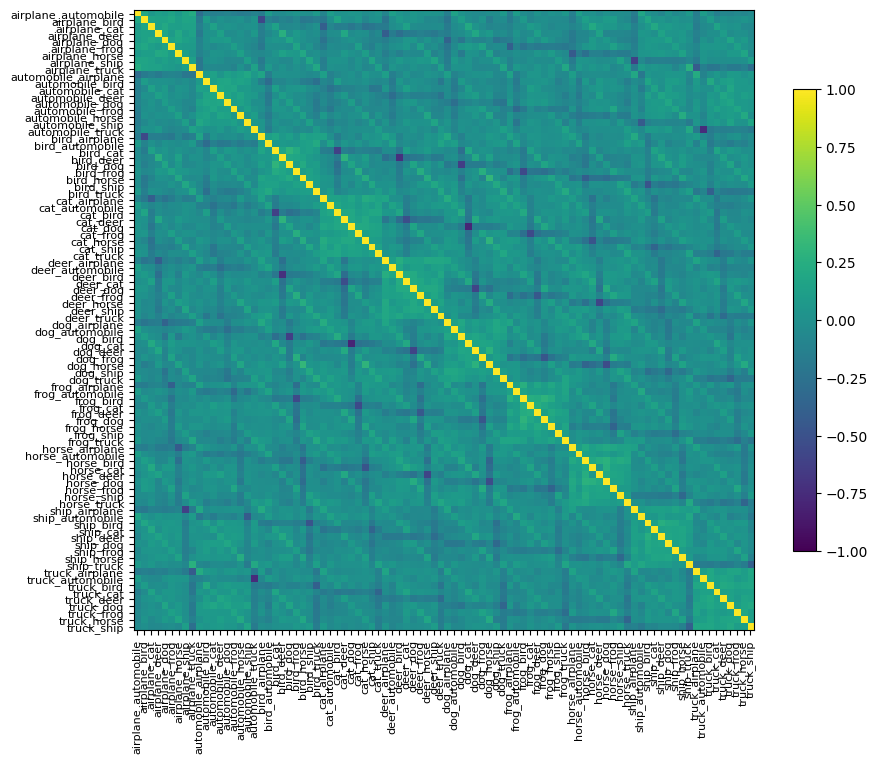

In [37]:
layer=11
category_to_category=os.listdir(f'{external_path}\\relative_concept_activation_vectors\\{layer}')
category_to_category=[c_to_c for c_to_c in category_to_category if 'training' not in c_to_c]
N=len(category_to_category)
dots=np.ones((N,N))
for n,c_to_c1 in enumerate(category_to_category):
    rel_cav1=torch.load(f'{external_path}\\relative_concept_activation_vectors\\{layer}\\{c_to_c1}')
    for m,c_to_c2 in enumerate(category_to_category):
        rel_cav2=torch.load(f'{external_path}\\relative_concept_activation_vectors\\{layer}\\{c_to_c2}')
        dots[n,m]=torch.dot(rel_cav1,rel_cav2)

fig,ax=plt.subplots(nrows=1,ncols=1)
fig.set_figheight(12)
fig.set_figwidth(10)
ax.set_yticks(ticks=np.arange(N),labels=[c_to_c.split('.')[0] for c_to_c in category_to_category],fontsize=8)
ax.set_xticks(ticks=np.arange(N),labels=[c_to_c.split('.')[0] for c_to_c in category_to_category],rotation='vertical',fontsize=8)
im=ax.imshow(dots,vmin=-1, vmax=1)
fig.colorbar(im,shrink=0.5)
plt.show()

In [10]:
cumulative_losses={}

for layer in range(13):
    layer_losses_file=open(f'{external_path}\\relative_concept_activation_vectors\\{layer}\\training_losses','rb')
    layer_losses=pickle.load(layer_losses_file)
    layer_losses_file.close()

    for relation in layer_losses.keys():
        if relation in cumulative_losses.keys():
            cumulative_losses[relation]=cumulative_losses[relation]+[layer_losses[relation]]
        else:
            cumulative_losses[relation]=[layer_losses[relation]]

cumulative_losses_df=pd.DataFrame.from_dict(cumulative_losses)

fig=px.line(cumulative_losses_df)

fig.update_layout(title="CAV Training Losses",xaxis_title="Layer",yaxis_title="Loss",legend_title="Relation")

fig.show()

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, in_dimension, out_dimension):
        super().__init__()
        self.layer=torch.nn.Linear(in_dimension,out_dimension)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer(x)

In [12]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('aaraki/vit-base-patch16-224-in21k-finetuned-cifar10')

mlp=MLP(768,10)

with torch.no_grad():
    mlp.layer.weight=torch.nn.Parameter(model.classifier.weight)
    mlp.layer.bias=torch.nn.Parameter(model.classifier.bias)

In [13]:
def layer_accuracy(category,categories,layer,classifier):
    for k in range(1,11):
        if k==1:
            activations=torch.load(f'{external_path}\\class_token_activations\\{category}\\layer{layer}_{k}.pt')
        else:
            activations=torch.cat([activations,torch.load(f'{external_path}\\class_token_activations\\{category}\\layer{layer}_{k}.pt')])
    acc=0
    count=0
    for row in activations:
        output=classifier(row)
        predicted_category=categories[output.argmax().item()]
        if predicted_category==category:
            acc+=1
        count+=1
    return acc/count

In [14]:
categories=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
layer_accuracies={}
progress_bar=tqdm(os.listdir(f'{external_path}\\class_token_activations'))
for category in progress_bar:
    layer_accuracies[category]=[]
    for layer in range(13):
        progress_bar.set_description(f'...processing {category} layer {layer}...')
        layer_accuracies[category].append(layer_accuracy(category,categories,layer,mlp))

layer_accuracies_df=pd.DataFrame.from_dict(layer_accuracies)
    
fig=px.line(layer_accuracies_df)

fig.update_layout(title="Layer Accuracies",xaxis_title="Layer",yaxis_title="Accuracy",legend_title="Category")

fig.show()

...processing truck layer 12...: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]    
